In [ ]:
from PIL import Image
import math
import scipy
import numpy as np
import imageio.v2 as iio
import matplotlib.pylab as plt
import os
import cv2

input_dir = 'exercise'
output_dir = 'output'
os.makedirs(output_dir,exist_ok=True)

def inverse_transform(image):
    return 255 - image

def gamma_correction(image, gamma=0.5):
    normalized = image / 255.0
    corrected = np.power(normalized, 1/gamma)
    return np.uint8(corrected * 255)

def log_transform(image):
    c = 255 / np.log(1 + np.max(image))
    log_image = c * np.log(1 + image.astype(np.float32))
    return np.uint8(log_image)

def histogram_equalization(image):
    if len(image.shape) == 2:
        return cv2.equalizeHist(image)
    else:
        ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)

def contrast_stretching(image):
    a = np.min(image)
    b = np.max(image)
    stretched = (image - a) * (255 / (b - a))
    return np.uint8(stretched)

methods = {
    'I': ('Inverse', inverse_transform),
    'G': ('Gamma', gamma_correction),
    'L': ('Log', log_transform),
    'H': ('HistEQ', histogram_equalization),
    'C': ('ContrastStretch', contrast_stretching)
}

def show_and_save(img, name, outpath):
    cv2.imshow(name, img)
    cv2.imwrite(outpath, img)

def process_images(method_key):
    if method_key not in methods:
        print("Phím không hợp lệ.")
        return
    method_name, method_func = methods[method_key]

    for filename in os.listdir(input_dir):
        path = os.path.join(input_dir, filename)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            continue

        processed = method_func(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        out_path = os.path.join(output_dir, f"{method_name}_{filename}")
        show_and_save(processed, f"{method_name} - {filename}", out_path)

    print(f"Đã xử lý tất cả ảnh với phương pháp {method_name}. Nhấn phím bất kỳ để tiếp tục...")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def main():
    print("Chọn phương thức xử lý ảnh")
    print("I - Image Inverse Transformation")
    print("G - Gamma Correction")
    print("L - Log Transformation")
    print("H - Histogram equalization")
    print("C - Contrast Stretching")
    key = input("Nhập (I/G/L/H/C): ").upper()
    process_images(key)
if __name__ == "__main__":
    main()


Chọn phương thức xử lý ảnh
I - Image Inverse Transformation
G - Gamma Correction
L - Log Transformation
H - Histogram equalization
C - Contrast Stretching
Đã xử lý tất cả ảnh với phương pháp Gamma. Nhấn phím bất kỳ để tiếp tục...


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

input_dir = 'exercise'
output_dir = 'output_2'
os.makedirs(output_dir, exist_ok=True)

def show_and_save(image, title, path):
    cv2.imshow(title, image)
    cv2.imwrite(path, image)

# FFT hiển thị magnitude spectrum
def fast_fourier_transform(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude = 20 * np.log(np.abs(fshift) + 1)
    return np.uint8(np.clip(magnitude, 0, 255))

# Butterworth lowpass filter
def butterworth_lowpass(img, cutoff=30, n=2):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2

    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)

    u = np.arange(0, rows)
    v = np.arange(0, cols)
    u, v = np.meshgrid(u - crow, v - ccol, indexing='ij')
    D = np.sqrt(u**2 + v**2)
    H = 1 / (1 + (D / cutoff)**(2*n))

    G = fshift * H
    img_back = np.fft.ifft2(np.fft.ifftshift(G))
    img_back = np.abs(img_back)
    return np.uint8(np.clip(img_back, 0, 255))

# Butterworth highpass filter
def butterworth_highpass(img, cutoff=30, n=2):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2

    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)

    u = np.arange(0, rows)
    v = np.arange(0, cols)
    u, v = np.meshgrid(u - crow, v - ccol, indexing='ij')
    D = np.sqrt(u**2 + v**2)
    H = 1 / (1 + (cutoff / D)**(2*n))
    H[D == 0] = 0  # tránh chia cho 0

    G = fshift * H
    img_back = np.fft.ifft2(np.fft.ifftshift(G))
    img_back = np.abs(img_back)
    return np.uint8(np.clip(img_back, 0, 255))

methods = {
    'F': ('FFT', fast_fourier_transform),
    'L': ('ButterLow', butterworth_lowpass),
    'H': ('ButterHigh', butterworth_highpass),
}

def process_images(method_key):
    if method_key not in methods:
        print("Phím không hợp lệ.")
        return

    method_name, method_func = methods[method_key]
    for filename in os.listdir(input_dir):
        path = os.path.join(input_dir, filename)
        img = cv2.imread(path)
        if img is None:
            continue

        result = method_func(img)
        save_path = os.path.join(output_dir, f"{method_name}_{filename}")
        show_and_save(result, f"{method_name} - {filename}", save_path)

    print(f"Đã xử lý tất cả ảnh với phương pháp {method_name}. Nhấn phím bất kỳ để tiếp tục...")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Giao diện menu
def main():
    print("Chọn phương pháp xử lý ảnh:")
    print("F - Fast Fourier Transform")
    print("L - Butterworth Lowpass Filter")
    print("H - Butterworth Highpass Filter")
    key = input("Nhập phím (F/L/H): ").upper()
    process_images(key)

if __name__ == '__main__':
    main()


Chọn phương pháp xử lý ảnh:
F - Fast Fourier Transform
L - Butterworth Lowpass Filter
H - Butterworth Highpass Filter


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20528\3321988215.py:55: RuntimeWarning: divide by zero encountered in divide
  H = 1 / (1 + (cutoff / D)**(2*n))


Đã xử lý tất cả ảnh với phương pháp ButterHigh. Nhấn phím bất kỳ để tiếp tục...


In [2]:
import os
import cv2
import numpy as np
import random
import math

input_dir = 'exercise'
output_dir = 'output_3'
os.makedirs(output_dir, exist_ok=True)

# Các hàm biến đổi ảnh
def inverse_transform(image):
    return 255 - image

def gamma_correction(image, gamma=0.5):
    normalized = image / 255.0
    corrected = np.power(normalized, 1 / gamma)
    return np.uint8(corrected * 255)

def log_transform(image):
    c = 255 / np.log(1 + np.max(image))
    log_image = c * np.log(1 + image.astype(np.float32))
    return np.uint8(log_image)

def histogram_equalization(image):
    if len(image.shape) == 2:
        return cv2.equalizeHist(image)
    else:
        ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)

def contrast_stretching(image):
    a = np.min(image)
    b = np.max(image)
    stretched = (image - a) * (255 / (b - a))
    return np.uint8(stretched)

# Danh sách hàm và tên tương ứng
methods = [
    ('Inverse', inverse_transform),
    ('Gamma', gamma_correction),
    ('Log', log_transform),
    ('HistEQ', histogram_equalization),
    ('ContrastStretch', contrast_stretching)
]

# Các hoán vị RGB
def shuffle_channels(image):
    permutations = [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
    order = random.choice(permutations)
    return image[:, :, list(order)]

# Xử lý ảnh
def process_images():
    for filename in os.listdir(input_dir):
        filepath = os.path.join(input_dir, filename)
        img = cv2.imread(filepath)

        if img is None:
            continue

        # 1. Xáo trộn RGB
        shuffled = shuffle_channels(img)

        # 2. Chọn ngẫu nhiên 1 phương pháp biến đổi
        method_name, method_func = random.choice(methods)

        # 3. Nếu cần thiết, chuyển sang grayscale
        if method_name != 'HistEQ':  # riêng histogram_equalization có thể dùng màu
            shuffled = cv2.cvtColor(shuffled, cv2.COLOR_BGR2GRAY)

        # 4. Biến đổi ảnh
        processed = method_func(shuffled)

        # 5. Lưu và hiển thị
        output_path = os.path.join(output_dir, f"{method_name}_{filename}")
        cv2.imwrite(output_path, processed)
        cv2.imshow(f"{method_name} - {filename}", processed)

    print("Đã xử lý xong tất cả ảnh. Nhấn phím bất kỳ để thoát.")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Hàm main
if __name__ == "__main__":
    process_images()


C:\Users\Admin\AppData\Local\Temp\ipykernel_24280\2749894863.py:21: RuntimeWarning: overflow encountered in scalar add
  c = 255 / np.log(1 + np.max(image))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24280\2749894863.py:21: RuntimeWarning: divide by zero encountered in log
  c = 255 / np.log(1 + np.max(image))


Đã xử lý xong tất cả ảnh. Nhấn phím bất kỳ để thoát.


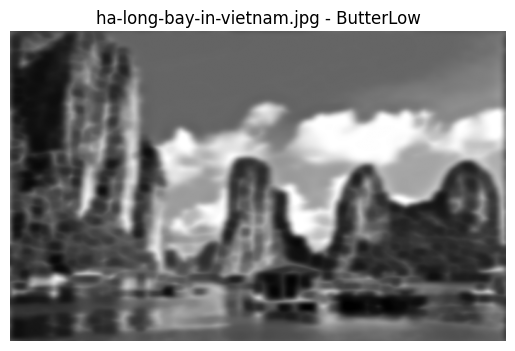

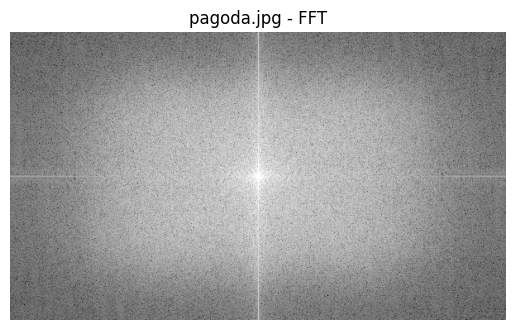

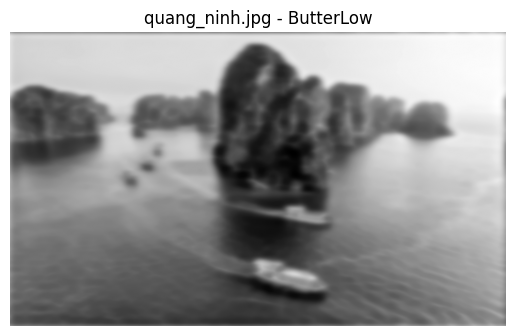

In [6]:
import os
import cv2
import numpy as np
import random
import math
from scipy.ndimage import minimum_filter, maximum_filter
import matplotlib.pyplot as plt


input_dir = 'exercise'
output_dir = 'output_4'
os.makedirs(output_dir, exist_ok=True)

# FFT hiển thị magnitude spectrum
def fast_fourier_transform(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude = 20 * np.log(np.abs(fshift) + 1)
    return np.uint8(np.clip(magnitude, 0, 255))

# Butterworth lowpass filter
def butterworth_lowpass(img, cutoff=30, n=2):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2

    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)

    u = np.arange(0, rows)
    v = np.arange(0, cols)
    u, v = np.meshgrid(u - crow, v - ccol, indexing='ij')
    D = np.sqrt(u**2 + v**2)
    H = 1 / (1 + (D / cutoff)**(2*n))

    G = fshift * H
    img_back = np.fft.ifft2(np.fft.ifftshift(G))
    img_back = np.abs(img_back)
    return np.uint8(np.clip(img_back, 0, 255))

# Butterworth highpass filter
def butterworth_highpass(img, cutoff=30, n=2):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2

    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)

    u = np.arange(0, rows)
    v = np.arange(0, cols)
    u, v = np.meshgrid(u - crow, v - ccol, indexing='ij')
    D = np.sqrt(u**2 + v**2)
    H = 1 / (1 + (cutoff / D)**(2*n))
    H[D == 0] = 0  # tránh chia cho 0

    G = fshift * H
    img_back = np.fft.ifft2(np.fft.ifftshift(G))
    img_back = np.abs(img_back)
    return np.uint8(np.clip(img_back, 0, 255))

methods = {
    'F': ('FFT', fast_fourier_transform),
    'L': ('ButterLow', butterworth_lowpass),
    'H': ('ButterHigh', butterworth_highpass),
}

# Áp dụng bộ lọc Min hoặc Max sau Butterworth
def apply_min_filter(img, size=3):
    return minimum_filter(img, size=size)

def apply_max_filter(img, size=3):
    return maximum_filter(img, size=size)

# Các hoán vị RGB
def shuffle_channels(image):
    permutations = [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
    order = random.choice(permutations)
    return image[:, :, list(order)]

# Xử lý từng ảnh
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img_path = os.path.join(input_dir, filename)
        img = cv2.imread(img_path)

        # B1: Hoán đổi kênh màu RGB
        img_shuffled = shuffle_channels(img)

        # B2: Ngẫu nhiên chọn phép biến đổi
        method_key = random.choice(list(methods.keys()))
        method_name, method_func = methods[method_key]
        transformed = method_func(img_shuffled)

        # B3: Nếu là Lowpass → Min Filter, Highpass → Max Filter
        if method_key == 'L':
            transformed = apply_min_filter(transformed)
        elif method_key == 'H':
            transformed = apply_max_filter(transformed)

        # B4: Lưu kết quả
        save_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_{method_name}.png")
        cv2.imwrite(save_path, transformed)

        # B5: Hiển thị
        plt.imshow(transformed, cmap='gray' if len(transformed.shape)==2 else None)
        plt.title(f"{filename} - {method_name}")
        plt.axis('off')
        plt.show()

